In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import DatasetDict, Dataset
from transformers import AutoTokenizer, AutoModelForMaskedLM
import tensorflow as tf
from sklearn.model_selection import train_test_split

c:\Users\Kalea\miniconda3\envs\tf_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preparation

In [2]:
df = pd.read_csv('../Data/STAGE 4 FINAL MERGED DATA/STAGE_4_MERGED_FINAL_ENCODED.csv')

In [3]:
df

,klasifikasi_perkara_encoded,penuntut_umum_encoded,hakim_encoded,jumlah_saksi,cleaned_barang_bukti,summarized_dakwaan,extracted_pasal,terdakwa,total_pidana_penjara_bulan
0,0,0,0,6,1 (satu) buah sabit kecil dengan gagang dari k...,Bahwa ia terdakwa Gede Darmayasa pada hari sel...,['Pasal 362 KUHP jo. Pasal 65 Ayat (1) KUHP'],GEDE DARMAYASA,5.0
1,0,0,1,6,1 (satu) buah Kotak/Box handphone merk OPPO ty...,Terdakwa Handri Johanes didakwa melakukan penc...,['Pasal 363 Ayat (1)'],HANDRI JOHANAS,4.0
2,1,1,2,2,1 (satu) buah plastik klip bening yang berisi ...,"Dakwaan Pertama: Pada 14 April 2024, sekitar p...",['Pasal 112 Ayat (1) UU No. 35 Tahun 2009 tent...,I GEDE ARIADI alias BERNAD,14.0
3,1,2,2,2,1 (satu) buah plastik klip bening yang berisi ...,"Dakwaan Pertama: Pada 14 April 2024, sekitar p...",['Pasal 112 Ayat (1) UU No. 35 Tahun 2009 tent...,I GEDE ARIADI alias BERNAD,14.0
4,0,3,2,4,1 (satu) unit sepeda motor merk Honda Scoopy w...,Pada 26 Maret 2024 pukul 17.10 WITA di pinggir...,['Pasal 362 KUHP'],R. Sabirin,14.0
...,...,...,...,...,...,...,...,...,...
154,0,56,14,4,2 (dua) buah MacBook Air merk Apple warna Grey...,I Gede Wahyu Arianta dan Feri Mananue didakwa ...,['Pasal 363 Ayat (1) ke-4 dan ke-5 KUHP'],GEDE WAHYU ARIANTA,26.0
155,0,56,14,4,2 (dua) buah MacBook Air merk Apple warna Grey...,I Gede Wahyu Arianta dan Feri Mananue didakwa ...,['Pasal 363 Ayat (1) ke-4 dan ke-5 KUHP'],FERI MANANUE,26.0
156,0,47,8,4,1 (satu) unit sepeda motor Yamaha RXS tahun 19...,Reza Aditya Pratama dan Kadek Agus Yudi Pranat...,['Pasal 363 Ayat (1) ke-3 dan ke-4 KUHP'],Reza Aditya Pratama Als Reza,20.0
157,0,47,8,4,1 (satu) unit sepeda motor Yamaha RXS tahun 19...,Reza Aditya Pratama dan Kadek Agus Yudi Pranat...,['Pasal 363 Ayat (1) ke-3 dan ke-4 KUHP'],Kadek Agus Yudi Pranata Als Agus,20.0


In [4]:
df_filtered = df.drop(columns=['extracted_pasal'])

In [5]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   klasifikasi_perkara_encoded  159 non-null    int64  
 1   penuntut_umum_encoded        159 non-null    int64  
 2   hakim_encoded                159 non-null    int64  
 3   jumlah_saksi                 159 non-null    int64  
 4   cleaned_barang_bukti         159 non-null    object 
 5   summarized_dakwaan           159 non-null    object 
 6   terdakwa                     159 non-null    object 
 7   total_pidana_penjara_bulan   159 non-null    float64
dtypes: float64(1), int64(4), object(3)
memory usage: 10.1+ KB


### Split Data

In [6]:
def stratified_split(df: pd.DataFrame, split_size: float = 0.7) -> tuple[pd.DataFrame, pd.DataFrame]:
    unique_groups = df.groupby(["klasifikasi_perkara_encoded", "penuntut_umum_encoded", "hakim_encoded"]).apply(lambda x: x.index.tolist()).to_dict()
    
    print(unique_groups)
    train_idx, test_idx = [], []
    
    for indices in unique_groups.values():        
        if len(indices) == 1:
            train_idx.extend(indices)
        else:
            train, test = train_test_split(indices, train_size=split_size, random_state=42)
            train_idx.extend(train)
            test_idx.extend(test)
    
    return df.loc[train_idx], df.loc[test_idx]

In [7]:
train_df, test_df = stratified_split(df_filtered)

{(0, 0, 0): [0, 18], (0, 0, 1): [1], (0, 3, 2): [4], (0, 3, 3): [8], (0, 7, 0): [13, 15], (0, 8, 0): [14, 16], (0, 9, 0): [17], (0, 9, 4): [26, 27], (0, 11, 3): [25], (0, 13, 4): [24], (0, 14, 0): [28], (0, 15, 0): [29], (0, 16, 0): [30], (0, 17, 0): [31, 32], (0, 18, 0): [33], (0, 20, 7): [37], (0, 21, 8): [38, 40], (0, 22, 8): [39, 103], (0, 22, 12): [85, 95, 96, 97, 99, 106], (0, 23, 8): [65, 87], (0, 23, 9): [41], (0, 24, 8): [42], (0, 25, 8): [43, 62], (0, 25, 11): [58], (0, 26, 8): [71, 72, 73], (0, 26, 10): [44], (0, 26, 11): [63, 64], (0, 27, 8): [45, 46, 47], (0, 27, 11): [67, 68], (0, 28, 8): [48, 59, 60, 61], (0, 28, 9): [49], (0, 28, 11): [55, 104, 105], (0, 29, 11): [50, 51], (0, 30, 8): [54], (0, 30, 9): [52, 56, 57], (0, 31, 8): [82, 92, 101], (0, 31, 9): [53, 69], (0, 31, 11): [102], (0, 31, 12): [77], (0, 32, 9): [66], (0, 33, 11): [70, 79], (0, 34, 11): [74, 75], (0, 34, 13): [100], (0, 35, 8): [83, 98, 107], (0, 35, 11): [76], (0, 35, 12): [78, 94], (0, 36, 11): [80]

C:\Users\Kalea\AppData\Local\Temp\ipykernel_46900\1615946564.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  unique_groups = df.groupby(["klasifikasi_perkara_encoded", "penuntut_umum_encoded", "hakim_encoded"]).apply(lambda x: x.index.tolist()).to_dict()


In [8]:
jenis_klasifikasi_perkara = train_df['klasifikasi_perkara_encoded'].unique()
jumlah_klasifikasi_perkara = len(jenis_klasifikasi_perkara)
print(f"Jumlah Klasifikasi Perkara: {jumlah_klasifikasi_perkara}")
print(f"Jumlah Data Train:  {len(train_df)}")

klasifikasi_perkara_values = train_df['klasifikasi_perkara_encoded'].value_counts()
print(klasifikasi_perkara_values)

Jumlah Klasifikasi Perkara: 3
Jumlah Data Train:  112
klasifikasi_perkara_encoded
0    98
1    12
2     2
Name: count, dtype: int64


In [9]:
jenis_klasifikasi_perkara = test_df['klasifikasi_perkara_encoded'].unique()
jumlah_klasifikasi_perkara = len(jenis_klasifikasi_perkara)
print(f"Jumlah Klasifikasi Perkara: {jumlah_klasifikasi_perkara}")
print(f"Jumlah Data Test:  {len(test_df)}")

klasifikasi_perkara_values = test_df['klasifikasi_perkara_encoded'].value_counts()
print(klasifikasi_perkara_values)

Jumlah Klasifikasi Perkara: 3
Jumlah Data Test:  47
klasifikasi_perkara_encoded
0    44
2     2
1     1
Name: count, dtype: int64


In [10]:
df_filtered

,klasifikasi_perkara_encoded,penuntut_umum_encoded,hakim_encoded,jumlah_saksi,cleaned_barang_bukti,summarized_dakwaan,terdakwa,total_pidana_penjara_bulan
0,0,0,0,6,1 (satu) buah sabit kecil dengan gagang dari k...,Bahwa ia terdakwa Gede Darmayasa pada hari sel...,GEDE DARMAYASA,5.0
1,0,0,1,6,1 (satu) buah Kotak/Box handphone merk OPPO ty...,Terdakwa Handri Johanes didakwa melakukan penc...,HANDRI JOHANAS,4.0
2,1,1,2,2,1 (satu) buah plastik klip bening yang berisi ...,"Dakwaan Pertama: Pada 14 April 2024, sekitar p...",I GEDE ARIADI alias BERNAD,14.0
3,1,2,2,2,1 (satu) buah plastik klip bening yang berisi ...,"Dakwaan Pertama: Pada 14 April 2024, sekitar p...",I GEDE ARIADI alias BERNAD,14.0
4,0,3,2,4,1 (satu) unit sepeda motor merk Honda Scoopy w...,Pada 26 Maret 2024 pukul 17.10 WITA di pinggir...,R. Sabirin,14.0
...,...,...,...,...,...,...,...,...
154,0,56,14,4,2 (dua) buah MacBook Air merk Apple warna Grey...,I Gede Wahyu Arianta dan Feri Mananue didakwa ...,GEDE WAHYU ARIANTA,26.0
155,0,56,14,4,2 (dua) buah MacBook Air merk Apple warna Grey...,I Gede Wahyu Arianta dan Feri Mananue didakwa ...,FERI MANANUE,26.0
156,0,47,8,4,1 (satu) unit sepeda motor Yamaha RXS tahun 19...,Reza Aditya Pratama dan Kadek Agus Yudi Pranat...,Reza Aditya Pratama Als Reza,20.0
157,0,47,8,4,1 (satu) unit sepeda motor Yamaha RXS tahun 19...,Reza Aditya Pratama dan Kadek Agus Yudi Pranat...,Kadek Agus Yudi Pranata Als Agus,20.0


In [11]:
train_df

,klasifikasi_perkara_encoded,penuntut_umum_encoded,hakim_encoded,jumlah_saksi,cleaned_barang_bukti,summarized_dakwaan,terdakwa,total_pidana_penjara_bulan
0,0,0,0,6,1 (satu) buah sabit kecil dengan gagang dari k...,Bahwa ia terdakwa Gede Darmayasa pada hari sel...,GEDE DARMAYASA,5.0
1,0,0,1,6,1 (satu) buah Kotak/Box handphone merk OPPO ty...,Terdakwa Handri Johanes didakwa melakukan penc...,HANDRI JOHANAS,4.0
4,0,3,2,4,1 (satu) unit sepeda motor merk Honda Scoopy w...,Pada 26 Maret 2024 pukul 17.10 WITA di pinggir...,R. Sabirin,14.0
8,0,3,3,4,1. 3 (tiga) buah bahan dasar kain (Baju Kaos) ...,Terdakwa RURY HERAWATI pada 20 November 2023 s...,RURY HERAWATI,16.0
13,0,7,0,6,1 (satu) unit sepeda motor merek Yamaha N-Max ...,Terdakwa I KETUT JONI ADNYANA ADI PUTRA dan Te...,I KETUT JONI ADNYANA ADI PUTRA,16.0
...,...,...,...,...,...,...,...,...
22,1,12,1,5,1 (satu) plastik klip bening yang berisi narko...,Dakwaan terhadap terdakwa Selamet Harianto ali...,SELAMET HARIANTO alias SELAMET,72.0
34,1,19,5,4,1 (satu) buah plastik klip bening yang berisi ...,Bahwa ia Terdakwa Anjar Ruchimat dan Irga Kris...,ANJAR RUCHIMAT,16.0
36,1,19,6,6,1 (satu) buah plastik klip bening yang berisi ...,"Terdakwa, Fenny Yanthi Esmidar, didakwa atas t...",FENNY YANTHI ESMIDAR,96.0
10,2,4,2,8,- 45 (empat puluh lima) lembar nota penjualan ...,"Tentu, berikut ringkasan dakwaan terhadap I Ke...",I KETUT SUPUTRA,18.0


## Model

### Model Preprocessing

In [12]:
train_df['concat_text'] = train_df[['cleaned_barang_bukti', 'summarized_dakwaan', 'terdakwa']].apply(lambda x: ' '.join(x), axis=1)
test_df['concat_text'] = test_df[['cleaned_barang_bukti', 'summarized_dakwaan', 'terdakwa']].apply(lambda x: ' '.join(x), axis=1)

In [13]:
y_train = train_df['total_pidana_penjara_bulan']
y_test = test_df['total_pidana_penjara_bulan']

### Tokenizer

In [14]:
tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")

def tokenize_function(text):
    return tokenizer(text['concat_text'], padding='max_length', truncation=True, max_length=512)

train_encodings = tokenizer(train_df['concat_text'].tolist(), padding=True, truncation=True, max_length=512)
test_encodings = tokenizer(test_df['concat_text'].tolist(), padding=True, truncation=True, max_length=512)

### Convert to Tensor

In [15]:
train_inputs = tf.constant(train_encodings['input_ids'])
train_attention_masks = tf.constant(train_encodings['attention_mask'])

test_inputs = tf.constant(test_encodings['input_ids'])
test_attention_masks = tf.constant(test_encodings['attention_mask'])

train_numerical = tf.constant(train_df[['klasifikasi_perkara_encoded', 'penuntut_umum_encoded', 'hakim_encoded', 'jumlah_saksi']].values, dtype=tf.float32)
test_numerical = tf.constant(test_df[['klasifikasi_perkara_encoded', 'penuntut_umum_encoded', 'hakim_encoded', 'jumlah_saksi']].values, dtype=tf.float32)

train_labels = tf.constant(y_train.values, dtype=tf.float32)
test_labels = tf.constant(y_test.values, dtype=tf.float32)

### Create Dataset from Tensor

In [16]:
import tensorflow as tf

def create_bert_regressor_dataset(input_ids, attention_mask, numerical_features, labels):
    dataset = tf.data.Dataset.from_tensor_slices(({
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'numerical_feature': numerical_features
    }, labels))
    return dataset

train_dataset = create_bert_regressor_dataset(train_inputs, train_attention_masks, train_numerical, train_labels)
test_dataset = create_bert_regressor_dataset(test_inputs, test_attention_masks, test_numerical, test_labels)

train_dataset = train_dataset.batch(2)
test_dataset = test_dataset.batch(2)


### Model Architecture

In [17]:
from transformers import TFBertModel
import tensorflow as tf

class BERTRegressor(tf.keras.Model):
    def __init__(self):
        super(BERTRegressor, self).__init__()
        self.bert = TFBertModel.from_pretrained("indolem/indobert-base-uncased", from_pt=True)

        for layer in self.bert.layers:
            layer.trainable = False
            
        self.regressor = tf.keras.layers.Dense(1)

    def call(self, inputs):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        numerical_features = inputs['numerical_feature']

        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.pooler_output

        combined_output = tf.concat([pooled_output, numerical_features], axis=1)

        return self.regressor(combined_output)

model = BERTRegressor()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predict

### Compile Model

In [18]:
model.compile(optimizer='adam',
              loss='mean_squared_error', metrics=['mean_absolute_error', tf.keras.metrics.RootMeanSquaredError()])

### Train Model

In [19]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10
56/56 [==============================] - 14s 101ms/step - loss: 388.8733 - mean_absolute_error: 14.3114 - root_mean_squared_error: 19.7199 - val_loss: 84.1871 - val_mean_absolute_error: 6.9498 - val_root_mean_squared_error: 9.1754
Epoch 2/10
56/56 [==============================] - 4s 71ms/step - loss: 235.0043 - mean_absolute_error: 8.7598 - root_mean_squared_error: 15.3299 - val_loss: 53.4399 - val_mean_absolute_error: 5.6612 - val_root_mean_squared_error: 7.3103
Epoch 3/10
56/56 [==============================] - 4s 70ms/step - loss: 215.3257 - mean_absolute_error: 8.5852 - root_mean_squared_error: 14.6740 - val_loss: 55.4666 - val_mean_absolute_error: 6.1782 - val_root_mean_squared_error: 7.4476
Epoch 4/10
56/56 [==============================] - 4s 70ms/step - loss: 211.3221 - mean_absolute_error: 8.7519 - root_mean_squared_error: 14.5369 - val_loss: 57.7617 - val_mean_absolute_error: 6.4160 - val_root_mean_squared_error: 7.6001
Epoch 5/10
56/56 [=======================

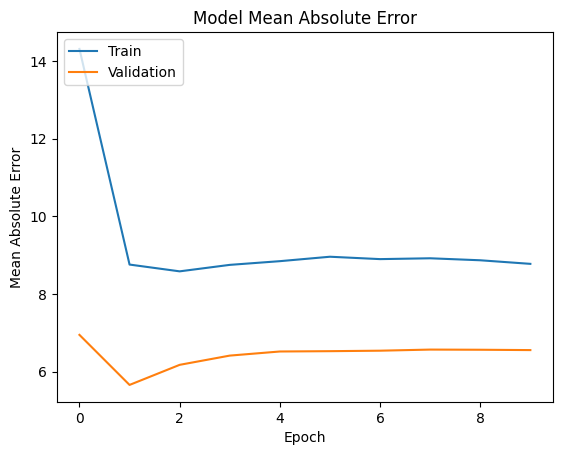

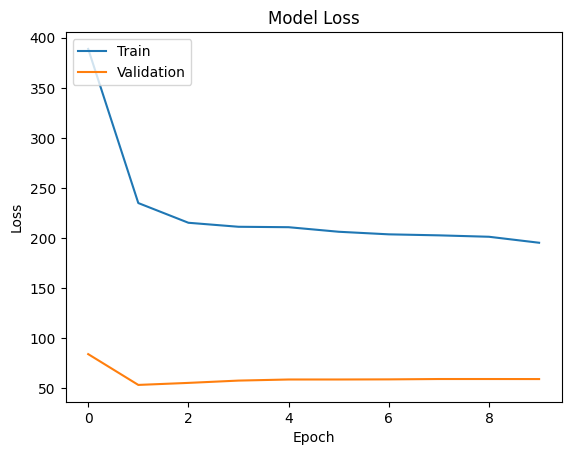

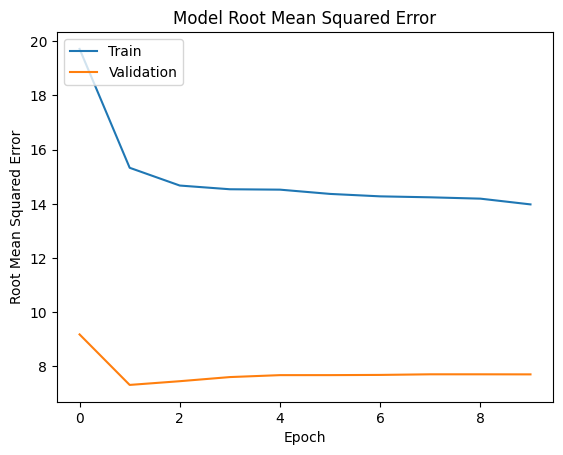

In [20]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model Root Mean Squared Error')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Inference

In [21]:
klasifikasi_perkara_encoded = 2
penuntut_umum_encoded = 9
hakim_encoded = 3
jumlah_saksi_inference = 3

inference_text = "1 (satu) unit sepeda motor yang sudah dimodifikasi (cetul) tanpa terpasang nomor registrasi / nomor polisi dan tidak dapat terdapat nomor rangka dan nomor mesin kendaraan Dikembalikan kepada I Gede Wiraguna 1 (satu) unit sepeda motor merek Kawasaki tipe LX 150 C, warna hitam kombinasi kuning, tahun pembuatan 2010, tanpa terpasang nomor registrasi / nomor polisi, Noka MH4LX150CAKP15705, Nosin LX150CEP19759 1 (satu) lembar SNTK sepeda motor merek Kawasaki tipe LX 150 C, warna hijau, tahun pembuatan 2010, nomor registrasi / nomor polisi DK 8164 IQ, Noka MH4LX150CAKP15705, Nosin LX150CEP19759, a.n. Chrisnawati, alamat Jl. Surabaya D, 6/20 Puri Gading, Jimbaran, Kuta Badung dan 1 (satu) buah buku BPKB, No H-0 2625520, DK 8164 IQ, merek Kawasaki tipe LX 150 C, Noka MH4LX150CAKP15705, Nosin LX150CEP19759, a.n. Chrisnawati, alamat Jl. Surabaya D, 6/20 Puri Gading, Jimbaran, Kuta Badung Dikembalikan kepada I Wayan Eva Kusuma Putra 6. Membebankan kepada Para Terdakwa membayar biaya perkara masing-masing sejumlah Rp5.000,00 (lima ribu rupiah) Terdakwa I, Rifqi Abdurahman, dan Terdakwa II, Gunawan, didakwa melakukan pencurian sepeda motor Kawasaki KLX 150 C di Jalan Raya Kayuambua, Bangli, pada 11 Desember 2022, sekitar pukul 00.30 WITA. Berawal dari permintaan Gunawan untuk mencarikan motor KLX, mereka berdua berangkat dari Denpasar ke Kintamani. Di lokasi kejadian, mereka melihat motor KLX tanpa kunci kontak. Rifqi mengambil motor tersebut dengan mendorongnya, sementara Gunawan mengawasi.  Karena Rifqi tidak bisa menyalakan motor, Gunawan membantu mendorongnya. Namun, motor mereka mengalami kerusakan, dan Rifqi melanjutkan mendorong motor curian sendirian. Saat mendorong, Rifqi bertemu saksi-saksi yang curiga dan menghubungi pemilik motor. Rifqi berhasil menyalakan motor, tetapi kehabisan bensin. Ia melanjutkan mendorong ke SPBU Sekardadi, di mana ia tertidur dan ditangkap polisi.  Gunawan ditangkap di Desa Dumilih. Motor curian dan motor yang digunakan para terdakwa disita. Korban, I Wayan Eva Kusuma Putra, mengalami kerugian Rp16.000.000. Para terdakwa didakwa melanggar Pasal 363 Ayat (1) Ke 4 KUHP sebagai dakwaan primair dan Pasal 362 KUHP sebagai dakwaan subsidair. RIFQI ABDURAHMAN"
inference_numerical_tensor = tf.constant([[klasifikasi_perkara_encoded, penuntut_umum_encoded, hakim_encoded, jumlah_saksi_inference]], dtype=tf.float32)
inputs = tokenizer(inference_text, padding=True, truncation=True, return_tensors='tf', max_length=512)

input_dict = {
    'input_ids': inputs['input_ids'],
    'attention_mask': inputs['attention_mask'],
    'numerical_feature': inference_numerical_tensor
}

In [22]:

predictions = model(input_dict)
predictions_np = predictions.numpy()

print(predictions_np)


[[19.095009]]


In [23]:
model.save('../Model/dummy_run_BERT')

INFO:tensorflow:Assets written to: ../Model/dummy_run_BERT\assets


INFO:tensorflow:Assets written to: ../Model/dummy_run_BERT\assets


## Saved Model Inference

In [24]:
tokenizer = AutoTokenizer.from_pretrained("indolem/indobert-base-uncased")

class BERTRegressor(tf.keras.Model):
    def __init__(self):
        super(BERTRegressor, self).__init__()
        self.bert = TFBertModel.from_pretrained("indolem/indobert-base-uncased", from_pt=True)
        for layer in self.bert.layers:
            layer.trainable = False
        self.regressor = tf.keras.layers.Dense(1)

    def call(self, inputs):
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        numerical_features = inputs['numerical_feature']

        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = bert_output.pooler_output
        combined_output = tf.concat([pooled_output, numerical_features], axis=1)

        return self.regressor(combined_output)

loaded_model = tf.keras.models.load_model('../Model/dummy_run_BERT', custom_objects={'BERTRegressor': BERTRegressor})

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predict

In [25]:
klasifikasi_perkara_encoded = 2
penuntut_umum_encoded = 4
hakim_encoded = 3
jumlah_saksi_inference = 3

inference_text = "1 (satu) unit sepeda motor yang sudah dimodifikasi (cetul) tanpa terpasang nomor registrasi / nomor polisi dan tidak dapat terdapat nomor rangka dan nomor mesin kendaraan Dikembalikan kepada I Gede Wiraguna 1 (satu) unit sepeda motor merek Kawasaki tipe LX 150 C, warna hitam kombinasi kuning, tahun pembuatan 2010, tanpa terpasang nomor registrasi / nomor polisi, Noka MH4LX150CAKP15705, Nosin LX150CEP19759 1 (satu) lembar SNTK sepeda motor merek Kawasaki tipe LX 150 C, warna hijau, tahun pembuatan 2010, nomor registrasi / nomor polisi DK 8164 IQ, Noka MH4LX150CAKP15705, Nosin LX150CEP19759, a.n. Chrisnawati, alamat Jl. Surabaya D, 6/20 Puri Gading, Jimbaran, Kuta Badung dan 1 (satu) buah buku BPKB, No H-0 2625520, DK 8164 IQ, merek Kawasaki tipe LX 150 C, Noka MH4LX150CAKP15705, Nosin LX150CEP19759, a.n. Chrisnawati, alamat Jl. Surabaya D, 6/20 Puri Gading, Jimbaran, Kuta Badung Dikembalikan kepada I Wayan Eva Kusuma Putra 6. Membebankan kepada Para Terdakwa membayar biaya perkara masing-masing sejumlah Rp5.000,00 (lima ribu rupiah) Terdakwa I, Rifqi Abdurahman, dan Terdakwa II, Gunawan, didakwa melakukan pencurian sepeda motor Kawasaki KLX 150 C di Jalan Raya Kayuambua, Bangli, pada 11 Desember 2022, sekitar pukul 00.30 WITA. Berawal dari permintaan Gunawan untuk mencarikan motor KLX, mereka berdua berangkat dari Denpasar ke Kintamani. Di lokasi kejadian, mereka melihat motor KLX tanpa kunci kontak. Rifqi mengambil motor tersebut dengan mendorongnya, sementara Gunawan mengawasi.  Karena Rifqi tidak bisa menyalakan motor, Gunawan membantu mendorongnya. Namun, motor mereka mengalami kerusakan, dan Rifqi melanjutkan mendorong motor curian sendirian. Saat mendorong, Rifqi bertemu saksi-saksi yang curiga dan menghubungi pemilik motor. Rifqi berhasil menyalakan motor, tetapi kehabisan bensin. Ia melanjutkan mendorong ke SPBU Sekardadi, di mana ia tertidur dan ditangkap polisi.  Gunawan ditangkap di Desa Dumilih. Motor curian dan motor yang digunakan para terdakwa disita. Korban, I Wayan Eva Kusuma Putra, mengalami kerugian Rp16.000.000. Para terdakwa didakwa melanggar Pasal 363 Ayat (1) Ke 4 KUHP sebagai dakwaan primair dan Pasal 362 KUHP sebagai dakwaan subsidair. RIFQI ABDURAHMAN"
inference_numerical_tensor = tf.constant([[klasifikasi_perkara_encoded, penuntut_umum_encoded, hakim_encoded, jumlah_saksi_inference]], dtype=tf.float32)
inputs = tokenizer(inference_text, padding=True, truncation=True, return_tensors='tf', max_length=512)

input_dict = {
    'input_ids': inputs['input_ids'],
    'attention_mask': inputs['attention_mask'],
    'numerical_feature': inference_numerical_tensor
}

In [26]:

predictions = loaded_model(input_dict)
predictions_np = predictions.numpy()

print(predictions_np)


[[18.834372]]
